# Biological Age Assessment Using DNA Methylation Data

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Loading & Exploration](#Data-Loading-&-Exploration)
3. [Preprocessing](#Preprocessing)
4. [Modeling](#Modeling)
    - [Model 1](#Model-1)
    - [Model 2](#Model-2)
    - [Model 3](#Model-3)
5. [Evaluation & Results](#Evaluation-&-Results)
6. [Conclusion](#Conclusion)


## Introduction

Aging is a complex biological process, the causes of which have remained rather elusive until very recently. Of course, many factors have their fair share of influence towards aging, but genetics is one of the most critical. While chronological age refers to how many years an individual has lived, biological age attempts to encapsulate the *"real"* age of a person's body, which can vary significantly from individual to individual.

Recent studies have shown that DNA methylation patterns are strong indicators of biological aging. In brief, methylation is a biochemical process where a methyl group (CH₃) is added to a molecule, such as DNA or a protein, without changing its original structure.

Going into a bit more technical depth, DNA methylation is a common epigenetic phenomenon. It represents a functional modification of genomic nucleic acid sequences that can affect gene expression without altering the DNA sequence itself. Its basic feature is that adding a methyl group to the DNA molecule significantly impacts gene regulation and cellular function. Methylation usually occurs at CpG sites, where a cytosine (C) base is adjacent to a guanine (G) base. The process is catalyzed by DNA methyltransferases, which selectively add methyl groups to specific bases.

In this project, I aimed to create a machine learning model that can accurately assess a person's biological age based on methylation data.

I worked with a large methylation dataset containing over 450,000 CpG sites, applied data cleaning and feature engineering, and trained a series of neural networks for the task. This notebook documents my complete journey — from raw data preprocessing to model evaluation.

I referred to Kaggle for both the dataset and much of the background information used in this project. The dataset link is provided below:

Kaggle Dataset Link: [https://www.kaggle.com/datasets/marquis03/age-assessment-and-disease-risk-prediction/data](https://www.kaggle.com/datasets/marquis03/age-assessment-and-disease-risk-prediction/data)


## Data Loading & Exploration

First and foremost, we will import all the required libraries for our project:
- Data manipulation and analysis (`pandas`, `numpy`)
- Data visualization (`matplotlib`, `seaborn`)
- Model training and evaluation (`scikit-learn`, `tensorflow.keras`)

These libraries will be used throughout the notebook for preprocessing the data, building neural networks, and evaluating model performance.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.losses import MeanSquaredError

The raw methylation dataset contains over 450,000 CpG sites across numerous samples. Due to its massive size, we load and process the data in chunks to avoid memory overload.

Steps performed in this cell:

- Load sample IDs from the metadata (`trainmap.csv`).
- Initialize an empty DataFrame to accumulate chunked methylation data.
- Read the methylation data from `traindata.csv` in chunks of 1000 rows (CpG sites).
- Transpose each chunk so that each row represents one sample, and each column a CpG site.
- Add `sample_id` back to each chunk to enable merging.
- Accumulate and merge all the chunks together into one DataFrame.
- Merge the final methylation matrix with the metadata to get the complete training dataset.

Note: For demonstration and testing purposes, we stop early after 10,000 CpG sites to speed up processing.

The result is `final_df`, a DataFrame that contains sample metadata along with the methylation values of the selected CpG sites.


In [5]:
trainmap=pd.read_csv("trainmap.csv")
sample_ids=trainmap['sample_id'].values

merged_df=pd.DataFrame({'sample_id': sample_ids})

data_file="D:/age assessment & disease risk prediction/traindata.csv"
header=pd.read_csv(data_file, nrows=0).columns

#total number of CpG sites (excluding header row)
total_sites=485512
chunk_size=1000

for start_row in range(1, total_sites+1, chunk_size):  #start from 1 to skip header
    print(f"Processing rows {start_row} to {start_row + chunk_size-1}")
    chunk=pd.read_csv(
        data_file,
        skiprows=range(1, start_row+1),
        nrows=chunk_size,
        header=None,
        low_memory=False
    )
    chunk.columns=header
    chunk=chunk.T 
    chunk=chunk.iloc[1:]  #drop first row (CpG site names)
    chunk=chunk.drop(columns=chunk.columns[0], errors='ignore')  #drop first column (CpG labels)

    chunk.columns=[f"site_{start_row+i}" for i in range(chunk.shape[1])] #rename columns to reflect CpG site range
    chunk['sample_id']=sample_ids
    merged_df=pd.merge(merged_df, chunk, on='sample_id')
    
    if start_row+chunk_size >= 10000:  #early stop
        break

#merge with full metadata
final_df=pd.merge(trainmap, merged_df, on='sample_id')

print("Final shape:", final_df.shape)

Processing rows 1 to 1000
Processing rows 1001 to 2000
Processing rows 2001 to 3000
Processing rows 3001 to 4000
Processing rows 4001 to 5000
Processing rows 5001 to 6000
Processing rows 6001 to 7000
Processing rows 7001 to 8000
Processing rows 8001 to 9000
Processing rows 9001 to 10000
Final shape: (8233, 9996)


In [6]:
final_df.head() #taking a look at what we have got in our hands

Unnamed: 0   sample_id   age gender     sample_type              disease  \
0           1  train10001  88.0      F  disease tissue  Alzheimer's disease   
1           2  train10002  92.0      F  disease tissue  Alzheimer's disease   
2           3  train10003  93.0      F  disease tissue  Alzheimer's disease   
3           4  train10004  96.0      F  disease tissue  Alzheimer's disease   
4           5  train10005  91.0      M  disease tissue  Alzheimer's disease   

              site_1 site_2             site_3            site_4  ...  \
0                NaN    NaN                NaN               NaN  ...   
1                NaN    NaN                NaN               NaN  ...   
2                NaN    NaN                NaN               NaN  ...   
3                NaN    NaN                NaN               NaN  ...   
4  -4.48985033042751    NaN  -3.99378119789195  1.31256712378897  ...   

           site_9990          site_9991           site_9992  \
0  -4.32215912121674  -3.65967218370334   -1.19114962492354   
1  -3.74475638342255  -3.34396996423399   -1.04052975408576   
2  -3.65967218370334  -3.54368910348732  -0.694497214515836   
3  -3.58095312394229  -3.50769127542286  -0.676546186134807   
4  -3.70135319968431  -3.47287398721241  -0.861430346736554   

           site_9993           site_9994          site_9995  \
0    -3.837360741878  -0.422073042516825  -3.17566111139105   
1  -3.99378119789195  -0.721627972472329  -2.76781847945269   
2    -3.837360741878  -0.730728000737965   -3.0299555377552   
3  -3.79003430577274  -0.832866088428596  -3.65967218370334   
4   -3.8869347922101   -0.77204548654538  -3.14998722323172   

           site_9996          site_9997          site_9998          site_9999  
0   0.45984499718504  -3.25654027895343  0.632117334040871  -3.05293380053206  
1  0.614515704865036  -2.84214102584214  0.694497214515836  -3.00744682892121  
2  0.934347217108321  -2.66472892622688   0.67207489221696  -3.12490441596849  
3   1.33666891307065  -3.70135319968431  0.636532494325869  -3.47287398721241  
4  0.472506352668666   -3.0764027276386  0.795271994459571  -3.17566111139105  

[5 rows x 9996 columns]

In [7]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8233 entries, 0 to 8232
Columns: 9996 entries, Unnamed: 0 to site_9999
dtypes: float64(1), int64(1), object(9994)
memory usage: 627.9+ MB


In [8]:
#getting the number of missing values in the table
final_df.isnull().sum()

Unnamed: 0       0
sample_id        0
age              0
gender          69
sample_type      0
              ... 
site_9995       36
site_9996        1
site_9997       97
site_9998      133
site_9999        8
Length: 9996, dtype: int64

Here, we can clearly see that there are quite a few columns with missing values, which are not suitable for training our model. Therefore, one by one we will try to address these issues.

In [9]:
#replacing the missing gender values with the most frequent
print(final_df['gender'].mode())

0    F
Name: gender, dtype: object


In [10]:
final_df=final_df.fillna(final_df['gender'].mode()[0])

Now, let us work on the CpG site columns, but before we go ahead and replace the NaNs with the mean of each column, we will ave to clean up the data a bit as there some inconsistencies to be taken care of — some data types aren't uniform throughout so will have to fix that [converting all the values to float]

Once that’s done, we’ll fill the missing values using the mean of each column. This is a quite commonly used strategy when dealing with numerical data. It helps retain the overall distribution of the data without introducing too much bias — especially when the percentage of missing values is low.

In [11]:
for col in final_df.columns:
    if col.startswith('site_'):
        clean_values=[]
        for val in final_df[col]:
            try:
                # Try converting directly
                clean_val=float(val)
            except:
                # If fails, try to extract numeric part using regex
                import re
                match=re.search(r'-?\d+\.\d+', str(val))
                if match:
                    clean_val=float(match.group())
                else:
                    clean_val=float('nan')  # Unable to convert
            clean_values.append(clean_val)
        final_df[col] = clean_values


In [12]:
# now we can replace the NaNs
for col in final_df.columns:
    if col.startswith('site_'):
        meanv = final_df[col].mean()
        final_df[col] = final_df[col].fillna(meanv)

In [13]:
# let us take a look at the cleaned up and complete data
final_df.head()

Unnamed: 0   sample_id   age gender     sample_type              disease  \
0           1  train10001  88.0      F  disease tissue  Alzheimer's disease   
1           2  train10002  92.0      F  disease tissue  Alzheimer's disease   
2           3  train10003  93.0      F  disease tissue  Alzheimer's disease   
3           4  train10004  96.0      F  disease tissue  Alzheimer's disease   
4           5  train10005  91.0      M  disease tissue  Alzheimer's disease   

     site_1    site_2    site_3    site_4  ...  site_9990  site_9991  \
0 -3.455726  2.228979 -3.589673  1.098937  ...  -4.322159  -3.659672   
1 -3.455726  2.228979 -3.589673  1.098937  ...  -3.744756  -3.343970   
2 -3.455726  2.228979 -3.589673  1.098937  ...  -3.659672  -3.543689   
3 -3.455726  2.228979 -3.589673  1.098937  ...  -3.580953  -3.507691   
4 -4.489850  2.228979 -3.993781  1.312567  ...  -3.701353  -3.472874   

   site_9992  site_9993  site_9994  site_9995  site_9996  site_9997  \
0  -1.191150  -3.837361  -0.422073  -3.175661   0.459845  -3.256540   
1  -1.040530  -3.993781  -0.721628  -2.767818   0.614516  -2.842141   
2  -0.694497  -3.837361  -0.730728  -3.029956   0.934347  -2.664729   
3  -0.676546  -3.790034  -0.832866  -3.659672   1.336669  -3.701353   
4  -0.861430  -3.886935  -0.772045  -3.149987   0.472506  -3.076403   

   site_9998  site_9999  
0   0.632117  -3.052934  
1   0.694497  -3.007447  
2   0.672075  -3.124904  
3   0.636532  -3.472874  
4   0.795272  -3.175661  

[5 rows x 9996 columns]

Ok, great! Now our training data is looking pretty good!
Let us go through the exact same procedure for our training data as well.

In [14]:
testmap=pd.read_csv("testmap.csv")
sample_ids=testmap['sample_id'].values
mergetest_df=pd.DataFrame({'sample_id': sample_ids})
test_file="D:/age assessment & disease risk prediction/testdata.csv"

header=pd.read_csv(test_file, nrows=0).columns
total_sites=485512
chunk_size=1000

for start_row in range(1, total_sites+1, chunk_size):
    print(f"Processing rows {start_row} to {start_row + chunk_size - 1}")
    chunk=pd.read_csv(
        test_file,
        skiprows=range(1, start_row + 1),
        nrows=chunk_size,
        header=None,
        low_memory=False
    )
    chunk.columns=header
    chunk=chunk.T
    chunk=chunk.iloc[1:] 
    chunk=chunk.drop(columns=chunk.columns[0], errors='ignore') 
    chunk.columns=[f"site_{start_row + i}" for i in range(chunk.shape[1])]
    
    chunk['sample_id'] = sample_ids
    mergetest_df = pd.merge(mergetest_df, chunk, on='sample_id')

    if start_row+chunk_size >= 10000:
        break

test_df=pd.merge(testmap, mergetest_df, on='sample_id')

print("Final shape:", test_df.shape)


Processing rows 1 to 1000
Processing rows 1001 to 2000
Processing rows 2001 to 3000
Processing rows 3001 to 4000
Processing rows 4001 to 5000
Processing rows 5001 to 6000
Processing rows 6001 to 7000
Processing rows 7001 to 8000
Processing rows 8001 to 9000
Processing rows 9001 to 10000
Final shape: (2063, 9993)


In [15]:
test_df.head()

Unnamed: 0  sample_id gender             site_1            site_2  \
0           1  test10001      M  -4.69054102388986               NaN   
1           2  test10002      M  -3.61957865344826  1.65772231236813   
2           3  test10003      F                NaN               NaN   
3           4  test10004      F                NaN               NaN   
4           5  test10005      M  -3.05293380053206               NaN   

              site_3            site_4             site_5             site_6  \
0  -4.11290824591452  1.09834569309202  -2.90129503316459  -4.40257845459822   
1  -3.05293380053206  1.15239450034479  -3.17566111139105  -4.24758297195416   
2                NaN               NaN  -1.33666891307065                NaN   
3                NaN               NaN  -1.06660744119774                NaN   
4  -4.48985033042751  1.30064081520407  -2.94254623412188  -4.58527052428126   

             site_7  ...          site_9990          site_9991  \
0  3.31403059244127  ...   -3.3747686203399  -3.50769127542286   
1  3.54368910348732  ...  -3.61957865344826  -3.61957865344826   
2  2.38811896204226  ...  -3.31403059244127  -3.43915998655532   
3               NaN  ...  -4.48985033042751  -3.50769127542286   
4  2.94254623412188  ...  -3.61957865344826  -3.61957865344826   

            site_9992          site_9993            site_9994  \
0   -1.07186281241192  -3.79003430577274    -1.31256712378897   
1  -0.979225991176352  -3.58095312394229  -0.0720167124091661   
2  -0.924493533152752  -3.99378119789195    -0.77204548654538   
3  -0.989323140307765  -4.58527052428126    -1.12518390027531   
4  -0.880658250893348  -3.79003430577274   -0.699001734548731   

           site_9995          site_9996          site_9997          site_9998  \
0  -2.94254623412188   0.37216329712597  -2.66472892622688  0.694497214515836   
1  -4.11290824591452  0.434629489708574  -3.47287398721241  0.799941688520153   
2  -2.82309628020982  0.347382932930862  -2.33727710024398  0.776674764245625   
3  -2.71511056419247  0.322707724296682  -2.28847956143452  0.739857099661147   
4  -2.84214102584214   0.66761006520794  -2.73241010363302  0.924493533152752   

           site_9999  
0  -3.14998722323172  
1  -2.92172966992679  
2  -2.90129503316459  
3  -3.25654027895343  
4  -3.14998722323172  

[5 rows x 9993 columns]

In [16]:
print(test_df['gender'].mode())

0    F
Name: gender, dtype: object


In [17]:
test_df=test_df.fillna(test_df['gender'].mode()[0])

In [18]:
for col in test_df.columns:
    if col.startswith('site_'):
        clean_values = []
        for val in test_df[col]:
            try:
                clean_val=float(val)
            except:
                import re
                match = re.search(r'-?\d+\.\d+', str(val))
                if match:
                    clean_val=float(match.group())
                else:
                    clean_val=float('nan')
            clean_values.append(clean_val)
        test_df[col] = clean_values


In [19]:
# now we can replace the NaNs
for col in test_df.columns:
    if col.startswith('site_'):
        meanv = test_df[col].mean()
        test_df[col] = test_df[col].fillna(meanv)

In [20]:
test_df.head()

Unnamed: 0  sample_id gender    site_1    site_2    site_3    site_4  \
0           1  test10001      M -4.690541  2.414894 -4.112908  1.098346   
1           2  test10002      M -3.619579  1.657722 -3.052934  1.152395   
2           3  test10003      F -3.358295  2.414894 -3.558260  1.099449   
3           4  test10004      F -3.358295  2.414894 -3.558260  1.099449   
4           5  test10005      M -3.052934  2.414894 -4.489850  1.300641   

     site_5    site_6    site_7  ...  site_9990  site_9991  site_9992  \
0 -2.901295 -4.402578  3.314031  ...  -3.374769  -3.507691  -1.071863   
1 -3.175661 -4.247583  3.543689  ...  -3.619579  -3.619579  -0.979226   
2 -1.336669 -4.043811  2.388119  ...  -3.314031  -3.439160  -0.924494   
3 -1.066607 -4.043811  3.505434  ...  -4.489850  -3.507691  -0.989323   
4 -2.942546 -4.585271  2.942546  ...  -3.619579  -3.619579  -0.880658   

   site_9993  site_9994  site_9995  site_9996  site_9997  site_9998  site_9999  
0  -3.790034  -1.312567  -2.942546   0.372163  -2.664729   0.694497  -3.149987  
1  -3.580953  -0.072017  -4.112908   0.434629  -3.472874   0.799942  -2.921730  
2  -3.993781  -0.772045  -2.823096   0.347383  -2.337277   0.776675  -2.901295  
3  -4.585271  -1.125184  -2.715111   0.322708  -2.288480   0.739857  -3.256540  
4  -3.790034  -0.699002  -2.842141   0.667610  -2.732410   0.924494  -3.149987  

[5 rows x 9993 columns]

Now, my first intuition was to just sum up all the methylation data to get one value to train the model, but that turned out to be grossly inaccurate. As there was no clear correlation with methylation sum and age, which can be understood by taking a look athe plot below.

Since, I didnot use this technique for my final models, these parts of the code have been commented out. I have not deleted them to preserve my original train of thoughts

In [21]:
# methylation_sums = []
# site_cols = [col for col in final_df.columns if col.startswith("site_")]

# for i in range(len(final_df)):
#     row_sum = 0
#     for col in site_cols:
#         val = final_df.at[i, col]
#         row_sum += 0 if pd.isna(val) else val
#     methylation_sums.append(row_sum)

# # Add new column
# final_df['methylation_sum'] = methylation_sums

# # Remove site columns
# final_df.drop(columns=site_cols, inplace=True)


In [22]:
final_df.head()

Unnamed: 0   sample_id   age gender     sample_type              disease  \
0           1  train10001  88.0      F  disease tissue  Alzheimer's disease   
1           2  train10002  92.0      F  disease tissue  Alzheimer's disease   
2           3  train10003  93.0      F  disease tissue  Alzheimer's disease   
3           4  train10004  96.0      F  disease tissue  Alzheimer's disease   
4           5  train10005  91.0      M  disease tissue  Alzheimer's disease   

     site_1    site_2    site_3    site_4  ...  site_9990  site_9991  \
0 -3.455726  2.228979 -3.589673  1.098937  ...  -4.322159  -3.659672   
1 -3.455726  2.228979 -3.589673  1.098937  ...  -3.744756  -3.343970   
2 -3.455726  2.228979 -3.589673  1.098937  ...  -3.659672  -3.543689   
3 -3.455726  2.228979 -3.589673  1.098937  ...  -3.580953  -3.507691   
4 -4.489850  2.228979 -3.993781  1.312567  ...  -3.701353  -3.472874   

   site_9992  site_9993  site_9994  site_9995  site_9996  site_9997  \
0  -1.191150  -3.837361  -0.422073  -3.175661   0.459845  -3.256540   
1  -1.040530  -3.993781  -0.721628  -2.767818   0.614516  -2.842141   
2  -0.694497  -3.837361  -0.730728  -3.029956   0.934347  -2.664729   
3  -0.676546  -3.790034  -0.832866  -3.659672   1.336669  -3.701353   
4  -0.861430  -3.886935  -0.772045  -3.149987   0.472506  -3.076403   

   site_9998  site_9999  
0   0.632117  -3.052934  
1   0.694497  -3.007447  
2   0.672075  -3.124904  
3   0.636532  -3.472874  
4   0.795272  -3.175661  

[5 rows x 9996 columns]

In [23]:
# # do the same on test set
# methylation_sums = []
# site_cols = [col for col in test_df.columns if col.startswith("site_")]

# for i in range(len(test_df)):
#     row_sum = 0
#     for col in site_cols:
#         val = test_df.at[i, col]
#         row_sum += 0 if pd.isna(val) else val
#     methylation_sums.append(row_sum)

# # Add new column
# test_df['methylation_sum'] = methylation_sums

# # Remove site columns
# test_df.drop(columns=site_cols, inplace=True)


In [24]:
test_df.head()

Unnamed: 0  sample_id gender    site_1    site_2    site_3    site_4  \
0           1  test10001      M -4.690541  2.414894 -4.112908  1.098346   
1           2  test10002      M -3.619579  1.657722 -3.052934  1.152395   
2           3  test10003      F -3.358295  2.414894 -3.558260  1.099449   
3           4  test10004      F -3.358295  2.414894 -3.558260  1.099449   
4           5  test10005      M -3.052934  2.414894 -4.489850  1.300641   

     site_5    site_6    site_7  ...  site_9990  site_9991  site_9992  \
0 -2.901295 -4.402578  3.314031  ...  -3.374769  -3.507691  -1.071863   
1 -3.175661 -4.247583  3.543689  ...  -3.619579  -3.619579  -0.979226   
2 -1.336669 -4.043811  2.388119  ...  -3.314031  -3.439160  -0.924494   
3 -1.066607 -4.043811  3.505434  ...  -4.489850  -3.507691  -0.989323   
4 -2.942546 -4.585271  2.942546  ...  -3.619579  -3.619579  -0.880658   

   site_9993  site_9994  site_9995  site_9996  site_9997  site_9998  site_9999  
0  -3.790034  -1.312567  -2.942546   0.372163  -2.664729   0.694497  -3.149987  
1  -3.580953  -0.072017  -4.112908   0.434629  -3.472874   0.799942  -2.921730  
2  -3.993781  -0.772045  -2.823096   0.347383  -2.337277   0.776675  -2.901295  
3  -4.585271  -1.125184  -2.715111   0.322708  -2.288480   0.739857  -3.256540  
4  -3.790034  -0.699002  -2.842141   0.667610  -2.732410   0.924494  -3.149987  

[5 rows x 9993 columns]

In [25]:
# plt.plot(final_df['methylation_sum'], final_df['age'], 'o')  # 'o' for scatter-like plot
# plt.xlabel('Methylation Sum')
# plt.ylabel('Age')
# plt.title('Methylation Sum vs Age')
# plt.grid(True)
# plt.show()

![Alt Text](Methylation_Sum_Plot(1).png)


Now we can clearly see that summing the methylation sites doesnot make sense, as the age range varies from 0 to 100 for the same value of methylbation sum, ie. there is no clear trend. Hence, we will have to look into which methylation CpG sites actually contribute more towards aging.

## Preprocessing

Here, we can see the diseases covered in the dataset. Although, this information is immaterial for our use while assessing the biological age, it will be very much required to predict age-related disease risks in the next notebook.

In [26]:
print(final_df['disease'].value_counts()) # list of diseases

disease
control                 6266
Alzheimer's disease      737
schizophrenia            381
Parkinson's disease      266
rheumatoid arthritis     159
stroke                   147
Huntington's disease     135
Graves' disease           58
type 2 diabetes           46
Sjogren's syndrome        38
Name: count, dtype: int64


Non-numeric values have no meaning for our model and hence are removed.

In [27]:
final_df.drop(columns='sample_id', inplace=True)
final_df.drop(columns='Unnamed: 0', inplace=True)
final_df.drop(columns='sample_type', inplace=True)
final_df.drop(columns='disease', inplace=True)
final_df.drop(columns='gender', inplace=True)

In [28]:
final_df.head()

age    site_1    site_2    site_3    site_4    site_5    site_6    site_7  \
0  88.0 -3.455726  2.228979 -3.589673  1.098937 -2.187223 -4.113303  3.476458   
1  92.0 -3.455726  2.228979 -3.589673  1.098937 -2.187223 -4.113303  3.476458   
2  93.0 -3.455726  2.228979 -3.589673  1.098937 -2.187223 -4.113303  3.476458   
3  96.0 -3.455726  2.228979 -3.589673  1.098937 -1.398461 -4.113303  3.476458   
4  91.0 -4.489850  2.228979 -3.993781  1.312567 -2.901295 -4.585271  2.804368   

     site_8    site_9  ...  site_9990  site_9991  site_9992  site_9993  \
0  4.052316 -3.625820  ...  -4.322159  -3.659672  -1.191150  -3.837361   
1  4.052316 -3.625820  ...  -3.744756  -3.343970  -1.040530  -3.993781   
2  4.052316 -3.625820  ...  -3.659672  -3.543689  -0.694497  -3.837361   
3  4.052316 -3.625820  ...  -3.580953  -3.507691  -0.676546  -3.790034   
4  2.985388 -4.402578  ...  -3.701353  -3.472874  -0.861430  -3.886935   

   site_9994  site_9995  site_9996  site_9997  site_9998  site_9999  
0  -0.422073  -3.175661   0.459845  -3.256540   0.632117  -3.052934  
1  -0.721628  -2.767818   0.614516  -2.842141   0.694497  -3.007447  
2  -0.730728  -3.029956   0.934347  -2.664729   0.672075  -3.124904  
3  -0.832866  -3.659672   1.336669  -3.701353   0.636532  -3.472874  
4  -0.772045  -3.149987   0.472506  -3.076403   0.795272  -3.175661  

[5 rows x 9991 columns]

We will do the same for the test set.

In [29]:
test_df.drop(columns='sample_id', inplace=True)
test_df.drop(columns='Unnamed: 0', inplace=True)
test_df.drop(columns='gender', inplace=True)

In [30]:
test_df.head()

site_1    site_2    site_3    site_4    site_5    site_6    site_7  \
0 -4.690541  2.414894 -4.112908  1.098346 -2.901295 -4.402578  3.314031   
1 -3.619579  1.657722 -3.052934  1.152395 -3.175661 -4.247583  3.543689   
2 -3.358295  2.414894 -3.558260  1.099449 -1.336669 -4.043811  2.388119   
3 -3.358295  2.414894 -3.558260  1.099449 -1.066607 -4.043811  3.505434   
4 -3.052934  2.414894 -4.489850  1.300641 -2.942546 -4.585271  2.942546   

     site_8    site_9   site_10  ...  site_9990  site_9991  site_9992  \
0  3.124904 -2.482634 -4.247583  ...  -3.374769  -3.507691  -1.071863   
1  3.100385 -4.112908 -4.247583  ...  -3.619579  -3.619579  -0.979226   
2  4.015720 -3.653304 -4.402578  ...  -3.314031  -3.439160  -0.924494   
3  4.015720 -3.653304 -3.938986  ...  -4.489850  -3.507691  -0.989323   
4  3.659672 -4.112908 -4.247583  ...  -3.619579  -3.619579  -0.880658   

   site_9993  site_9994  site_9995  site_9996  site_9997  site_9998  site_9999  
0  -3.790034  -1.312567  -2.942546   0.372163  -2.664729   0.694497  -3.149987  
1  -3.580953  -0.072017  -4.112908   0.434629  -3.472874   0.799942  -2.921730  
2  -3.993781  -0.772045  -2.823096   0.347383  -2.337277   0.776675  -2.901295  
3  -4.585271  -1.125184  -2.715111   0.322708  -2.288480   0.739857  -3.256540  
4  -3.790034  -0.699002  -2.842141   0.667610  -2.732410   0.924494  -3.149987  

[5 rows x 9990 columns]

Before we proceed with model training, we will be performing some essential preprocessing steps to make the data better suitable for machine learning. First, we will scale the `age` column using `StandardScaler`, storing the result in a new column called `age_scaled`. This is necessary because the raw age values span a wide range, and neural networks tend to perform better when the target variable is normalized to have zero mean and unit variance. Scaling helps the model converge faster and ensures it isn't biased toward features with larger numerical magnitudes.

Next, we will separate the input features and the target. Both `age` and `age_scaled` will be dropped from the feature dataframe, as we aim to predict `age_scaled`, and including it among the features would'nt make sesne. We'll also ensure that all feature values are converted to float type for consistency.

After that, we will split the dataset into training and cross-validation sets using an 80-20 ratio. Setting a fixed `random_state` ensures reproducibility of the results across different runs. This allows us to train the model on one portion of the data and evaluate it on unseen data, helping us better understand how well the model has learnt.

Finally, all pandas DataFrames will be converted into NumPy arrays. Since TensorFlow expects inputs in array format, this conversion is required for compatibility during model training. And, now are data is ready to be fed to our neural network.


In [31]:
age_scaler=StandardScaler()
final_df['age_scaled'] = age_scaler.fit_transform(final_df[['age']])

C:\Users\Devansh Shah\AppData\Local\Temp\ipykernel_9612\1323220512.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df['age_scaled'] = age_scaler.fit_transform(final_df[['age']])


In [32]:
X_df = final_df.drop(columns=['age', 'age_scaled']).astype(float)
y_df = final_df['age_scaled'].astype(float)

In [33]:
x_train_df, x_cv_df, y_train, y_cv = train_test_split(X_df, y_df, test_size=0.2, random_state=7)

In [34]:
x_train = x_train_df.to_numpy()
x_cv = x_cv_df.to_numpy()
y_train = y_train.to_numpy()
y_cv = y_cv.to_numpy()


In [35]:
x_train.shape

(6586, 9990)

In [36]:
x_cv.shape

(1647, 9990)

In [37]:
y_train.shape

(6586,)

In [38]:
y_cv.shape

(1647,)

In [39]:
print(x_train.dtype)

float64


## Modeling

### Model 1

To begin modeling, let's build a neural network using `tensorflow.keras`. The model will consist of four hidden layers with 1024, 512, 128, and 32 neurons respectively, each using the ReLU activation function. The final output layer will have one neuron with a linear activation, as this is a regression task where we aim to predict a continuous target — the scaled biological age.

Then we will compile the model using the Adam optimizer, a widely used adaptive learning rate algorithm, and set the loss function to Mean Squared Error (MSE), which is appropriate for regression problems. The model will be trained for 100 epochs on the training data, with training loss monitored at each epoch. After training, the model will be evaluated on the cross-validation set to generate predictions, which we will then inverse-transform to bring back to the original age scale. This will allow us to interpret the predicted biological ages in meaningful units (years).


In [41]:
model = Sequential([
    Dense(1024, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

C:\Users\Devansh Shah\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.compile(optimizer='adam', loss=MeanSquaredError())

Here, it might seem that we have trained the model only in 10 epochs but that actually is not the case. In reality, I trained the model in small chunks of steps to analyse it's performance and how much training led to the best results. So, approximately 100-130 steps were taken to train this model to its most accurate version.

In [448]:
model.fit(x_train, y_train, epochs=1)

206/206 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - loss: 0.0260


In [449]:
y_cvpred = model.predict(x_cv)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [450]:
y_cvpred.shape

(1647, 1)

In [451]:
y_cv.shape

(1647,)

In [452]:
y_cv_actual = age_scaler.inverse_transform(y_cv.reshape(-1, 1))
y_cv_pred_actual = age_scaler.inverse_transform(y_cvpred.reshape(-1, 1))



Ok! Now let us visualize it's performance by plotting the predicted biological ages against the actual ages from the cross-validation set.

Each red dot will represent a single data point, and the dashed blue line will correspond to the ideal case where the predicted age exactly equals the actual age (i.e., **y = x**).

Points lying close to this line will indicate accurate predictions, while points further away will represent higher prediction error. This plot will provide an intuitive understanding of how well the model is fitting the data and where it tends to over- or under-predict.


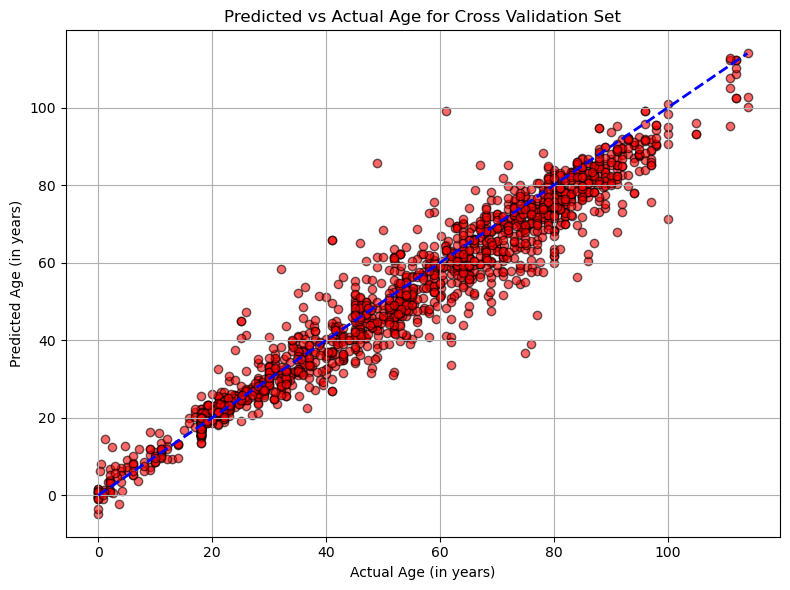

In [453]:
# this is the graph corresponding the cross validation set
plt.figure(figsize=(8, 6))
plt.scatter(y_cv_actual, y_cv_pred_actual, alpha=0.6, color='red', edgecolors='k')
plt.plot([y_cv_actual.min(), y_cv_actual.max()], [y_cv_actual.min(), y_cv_actual.max()], 'b--', lw=2)  # y = x line
plt.xlabel('Actual Age (in years)')
plt.ylabel('Predicted Age (in years)')
plt.title('Predicted vs Actual Age for Cross Validation Set')
plt.grid(True)
plt.tight_layout()
plt.show()


Hmm, now let us use our test data to predict and see how well our model performs. One thing to note, however, is that since our test data doesn't have the actual age labels, we won't be able to assess its performance directly. 

So, we will have to rely on distribution graphs to help us understand whether the test data distribution aligns well with that of the train and cross-validation sets.


In [460]:
test_pred = model.predict(test_df)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 


In [461]:
test_pred.shape

(2063, 1)

This histogram shows the distribution of biological age predictions generated by our model on the test dataset. On the x-axis, we have the predicted age in years, while the y-axis shows the frequency of those predictions.

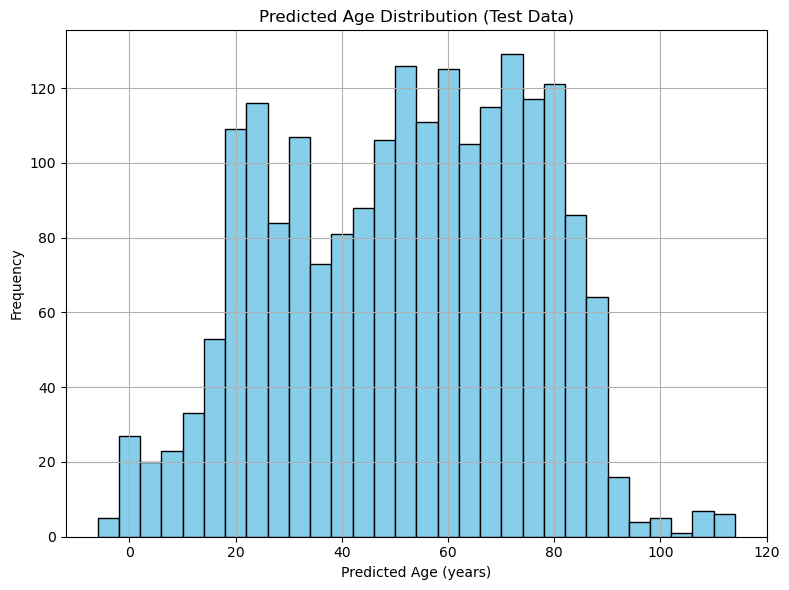

In [462]:
# now we plot for our test data frame
# Inverse transform predictions to get ages in years
test_pred_actual = age_scaler.inverse_transform(test_pred.reshape(-1, 1))

plt.figure(figsize=(8, 6))
plt.hist(test_pred_actual, bins=30, color='skyblue', edgecolor='black')
plt.title('Predicted Age Distribution (Test Data)')
plt.xlabel('Predicted Age (years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()



The distribution appears fairly continuous and bell-shaped, resembling a reasonable age distribution with a broad coverage from very young (near 0) to very old (near 100+). This indicates that our model is not collapsing to a narrow age range and is able to generalize across different age groups.

This line plot shows predicted ages on the test data, sorted in increasing order. The x-axis represents the index (sorted sample), while the y-axis represents the predicted biological age.

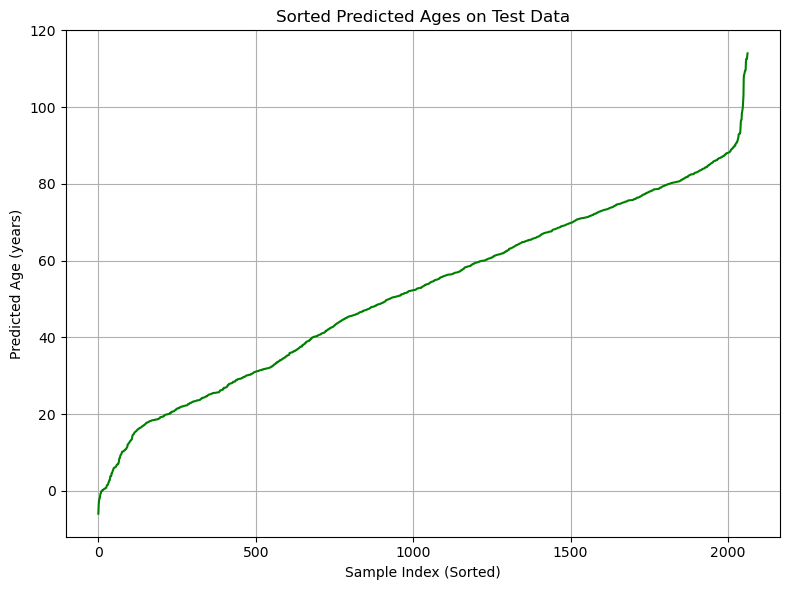

In [463]:
sorted_pred = np.sort(test_pred_actual.reshape(-1))

plt.figure(figsize=(8, 6))
plt.plot(sorted_pred, color='green')
plt.title('Sorted Predicted Ages on Test Data')
plt.xlabel('Sample Index (Sorted)')
plt.ylabel('Predicted Age (years)')
plt.grid(True)
plt.tight_layout()
plt.show()


The curve increases smoothly without abrupt jumps or flat regions. This smoothness indicates that the model is not producing overly repetitive or erratic predictions — it is likely capturing the continuous nature of aging well.

This composite histogram compares the age distributions across the training set (blue), validation (orange), and test predictions (green). All are plotted over the same age range.

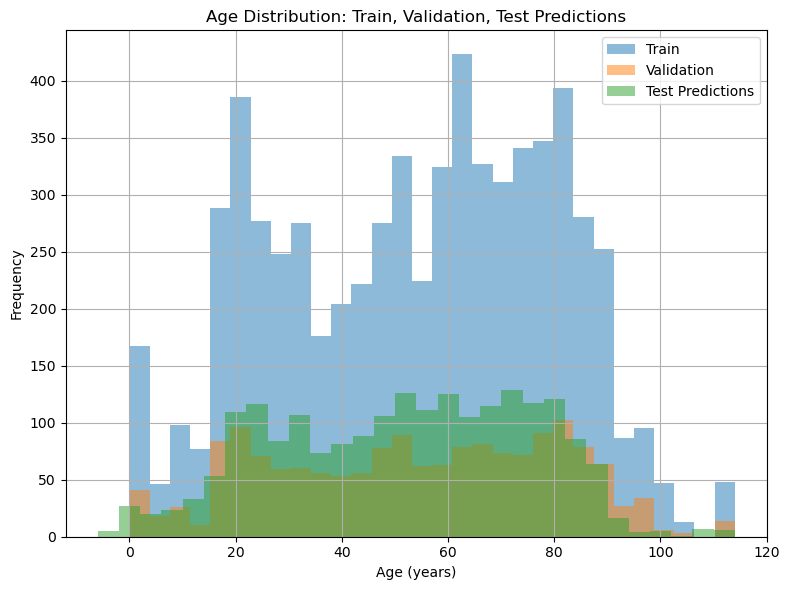

In [464]:
train_actual = age_scaler.inverse_transform(y_train.reshape(-1, 1))
val_actual = age_scaler.inverse_transform(y_cv.reshape(-1, 1))

plt.figure(figsize=(8, 6))
plt.hist(train_actual, bins=30, alpha=0.5, label='Train')
plt.hist(val_actual, bins=30, alpha=0.5, label='Validation')
plt.hist(test_pred_actual, bins=30, alpha=0.5, label='Test Predictions')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age Distribution: Train, Validation, Test Predictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The test predictions (green) follow the same general distribution shape as the training and validation data, although slightly more smoothed. Some gaps visible in the validation distribution (possibly due to fewer samples) are more evenly filled in the test prediction.


Together, these plots help validate that the model is producing reasonable and consistent outputs on test data, even in the absence of ground-truth labels.

### Model 2
Huge reduction in number of layers and neurons. Mainly to test the performance a more computationally efficient model.

In [305]:
model_2 = Sequential([
    # Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model_2.compile(optimizer='adam', loss=MeanSquaredError())


C:\Users\Devansh Shah\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Here, it might seem that we have trained the model only in 5 epochs but that actually is not the case. In reality, I trained the model in small chunks of steps to analyse it's performance and how much training led to the best results. So, approximately 100-130 steps were taken to train this model to its most accurate version.

In [455]:
model_2.fit(x_train, y_train, epochs=5) 

Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0240
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0213
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0470 
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0386 
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0293 


In [456]:
y_cvpred_2 = model_2.predict(x_cv)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [457]:
y_cv_actual_2 = age_scaler.inverse_transform(y_cv.reshape(-1, 1))
y_cv_pred_actual_2 = age_scaler.inverse_transform(y_cvpred_2.reshape(-1, 1))

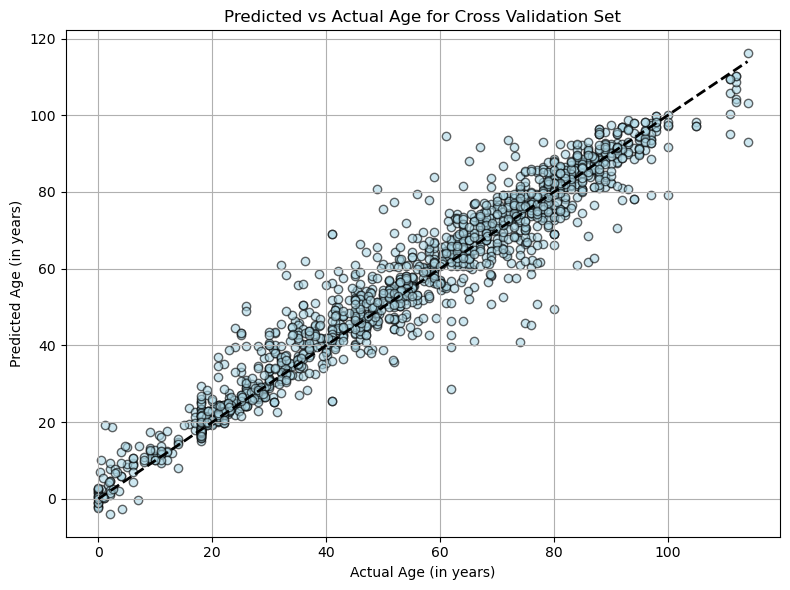

In [458]:
# this is the graph corresponding the cross validation set
plt.figure(figsize=(8, 6))
plt.scatter(y_cv_actual_2, y_cv_pred_actual_2, alpha=0.6, color='lightblue', edgecolors='k')
plt.plot([y_cv_actual_2.min(), y_cv_actual_2.max()], [y_cv_actual_2.min(), y_cv_actual_2.max()], 'k--', lw=2)  # y = x line
plt.xlabel('Actual Age (in years)')
plt.ylabel('Predicted Age (in years)')
plt.title('Predicted vs Actual Age for Cross Validation Set')
plt.grid(True)
plt.tight_layout()
plt.show()


Hmm, model 1 and model 2 look quite close in performace. Let us compare and contrast them by plotting their test predictions side by side, using the same previous 3 plot configurations! 


Note: As I have discussed these plots in depth before, I won't be explaining the intuition again.

In [465]:
test_pred_2 = model_2.predict(test_df)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [466]:
test_pred_actual_2 = age_scaler.inverse_transform(test_pred_2.reshape(-1, 1))

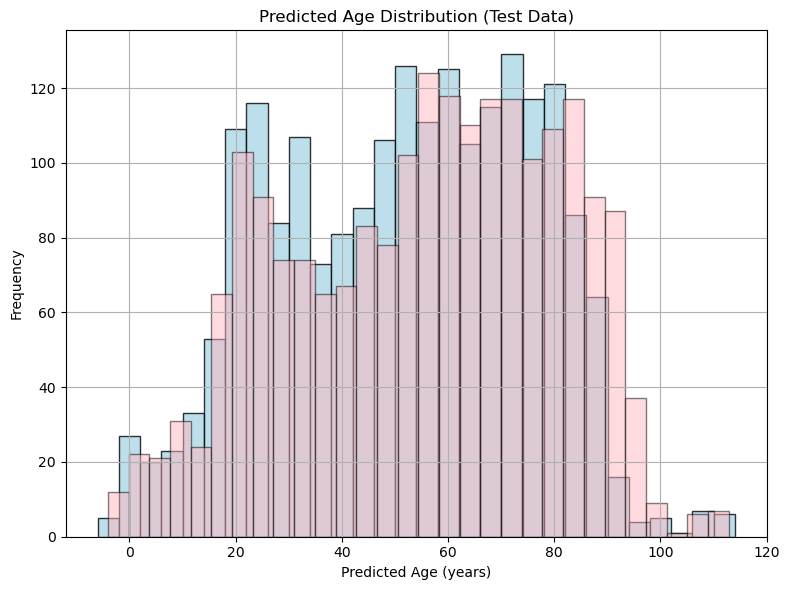

In [467]:
plt.figure(figsize=(8, 6))
plt.hist(test_pred_actual, bins=30, alpha=0.8, color='lightblue', edgecolor='black')
plt.hist(test_pred_actual_2, bins=30, alpha=0.5, color='lightpink', edgecolor='black')
plt.title('Predicted Age Distribution (Test Data)')
plt.xlabel('Predicted Age (years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [469]:
# a subtle difference! nothing substantial

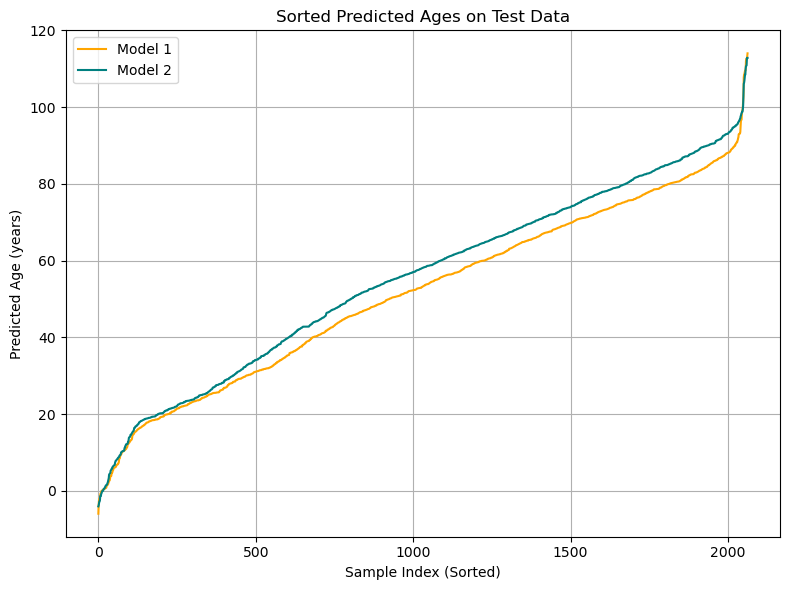

In [470]:
# Sort both prediction arrays
sorted_pred_1 = np.sort(test_pred_actual.reshape(-1))
sorted_pred_2 = np.sort(test_pred_actual_2.reshape(-1))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(sorted_pred_1, label='Model 1', color='orange')
plt.plot(sorted_pred_2, label='Model 2', color='teal')
plt.title('Sorted Predicted Ages on Test Data')
plt.xlabel('Sample Index (Sorted)')
plt.ylabel('Predicted Age (years)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [471]:
# again a subtle difference

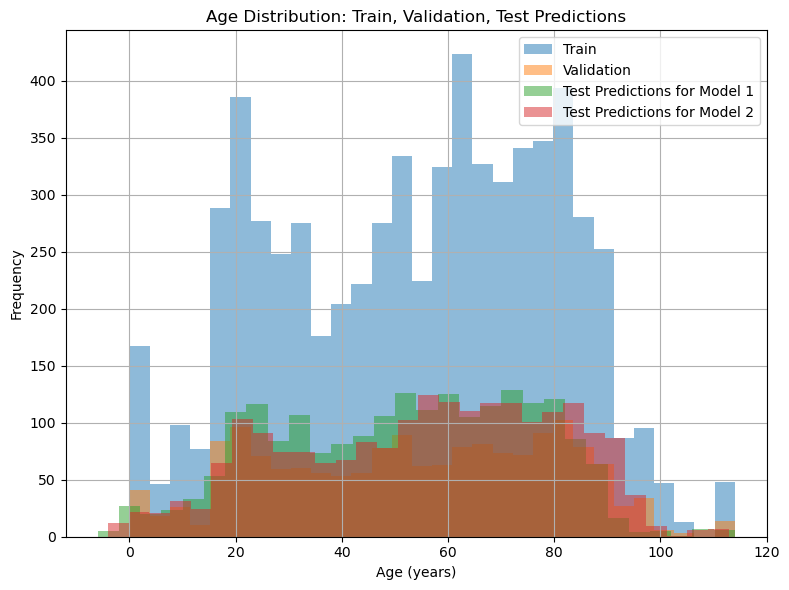

In [472]:
train_actual = age_scaler.inverse_transform(y_train.reshape(-1, 1))
val_actual = age_scaler.inverse_transform(y_cv.reshape(-1, 1))

plt.figure(figsize=(8, 6))
plt.hist(train_actual, bins=30, alpha=0.5, label='Train')
plt.hist(val_actual, bins=30, alpha=0.5, label='Validation')
plt.hist(test_pred_actual, bins=30, alpha=0.5, label='Test Predictions for Model 1')
plt.hist(test_pred_actual_2, bins=30, alpha=0.5, label='Test Predictions for Model 2')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age Distribution: Train, Validation, Test Predictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


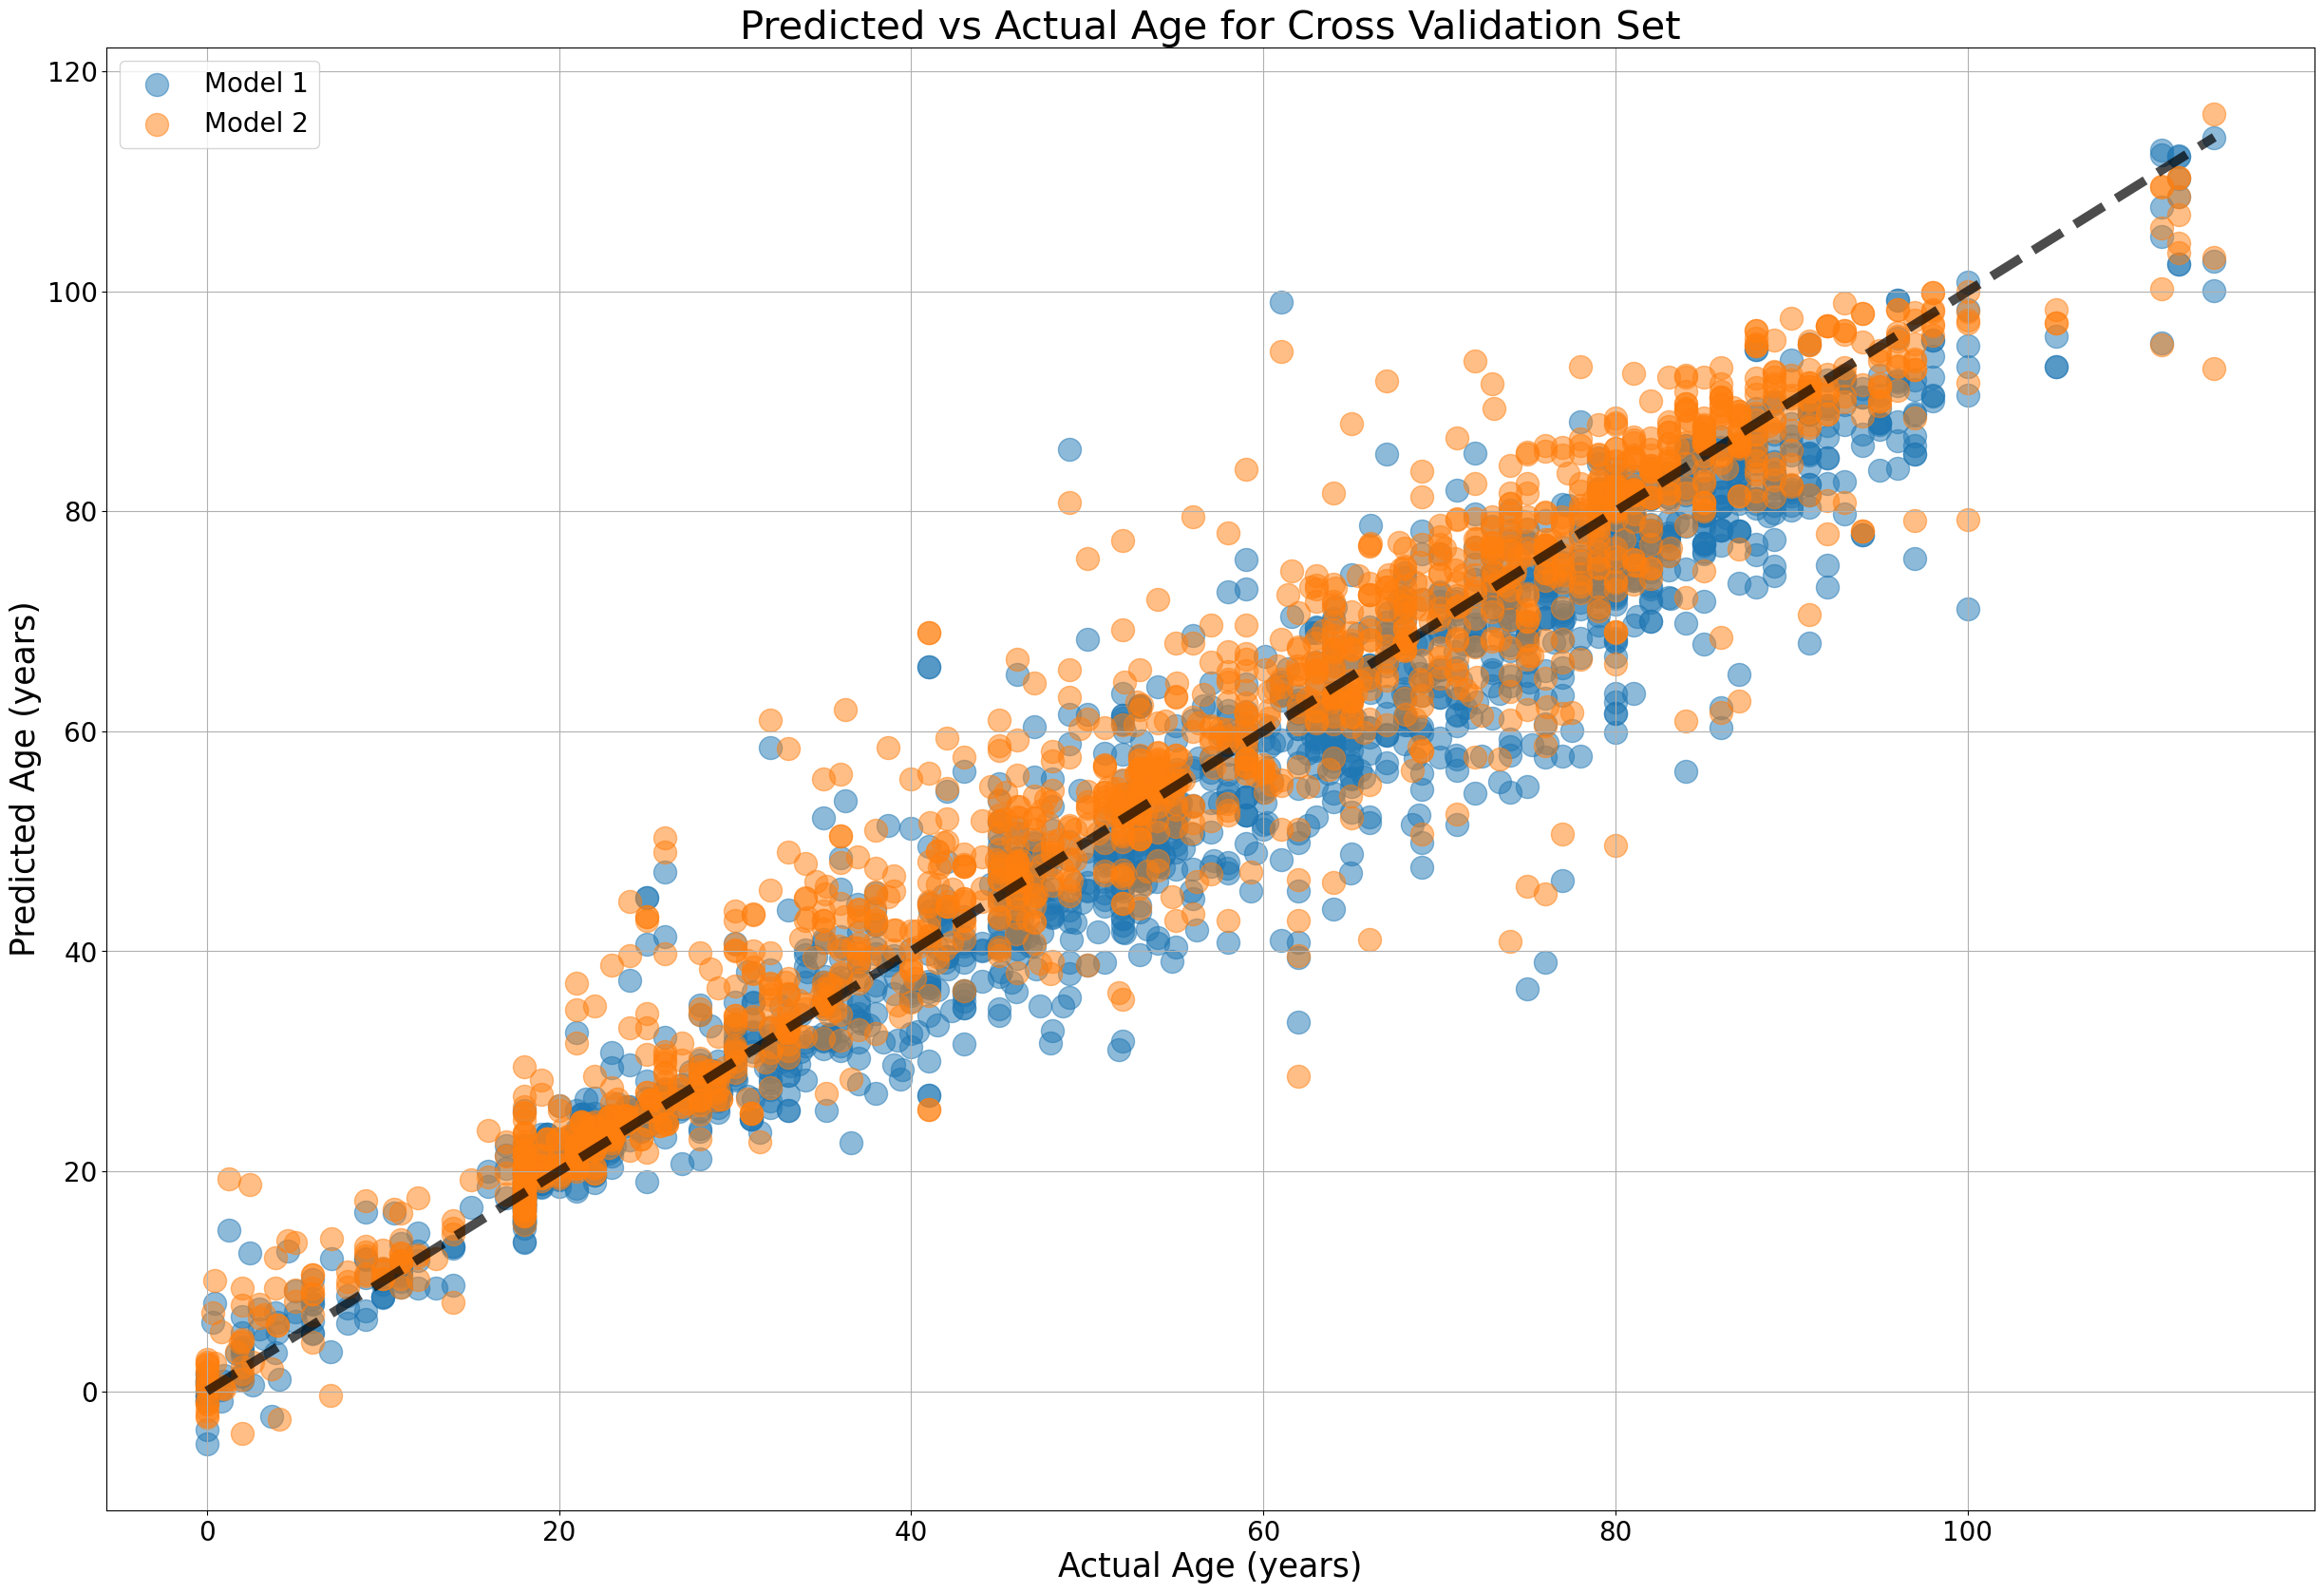

In [473]:
plt.figure(figsize=(30, 20))
plt.scatter(y_cv_actual, y_cv_pred_actual, label='Model 1', alpha=0.5, s=300)
plt.scatter(y_cv_actual_2, y_cv_pred_actual_2, label='Model 2', alpha=0.5, s=300)
plt.plot([y_cv_actual_2.min(), y_cv_actual_2.max()], [y_cv_actual_2.min(), y_cv_actual_2.max()], 'k--', alpha=0.7, lw=7)
plt.xlabel('Actual Age (years)', fontsize=25)
plt.ylabel('Predicted Age (years)', fontsize=25)
plt.title('Predicted vs Actual Age for Cross Validation Set', fontsize=30)
plt.grid(True)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


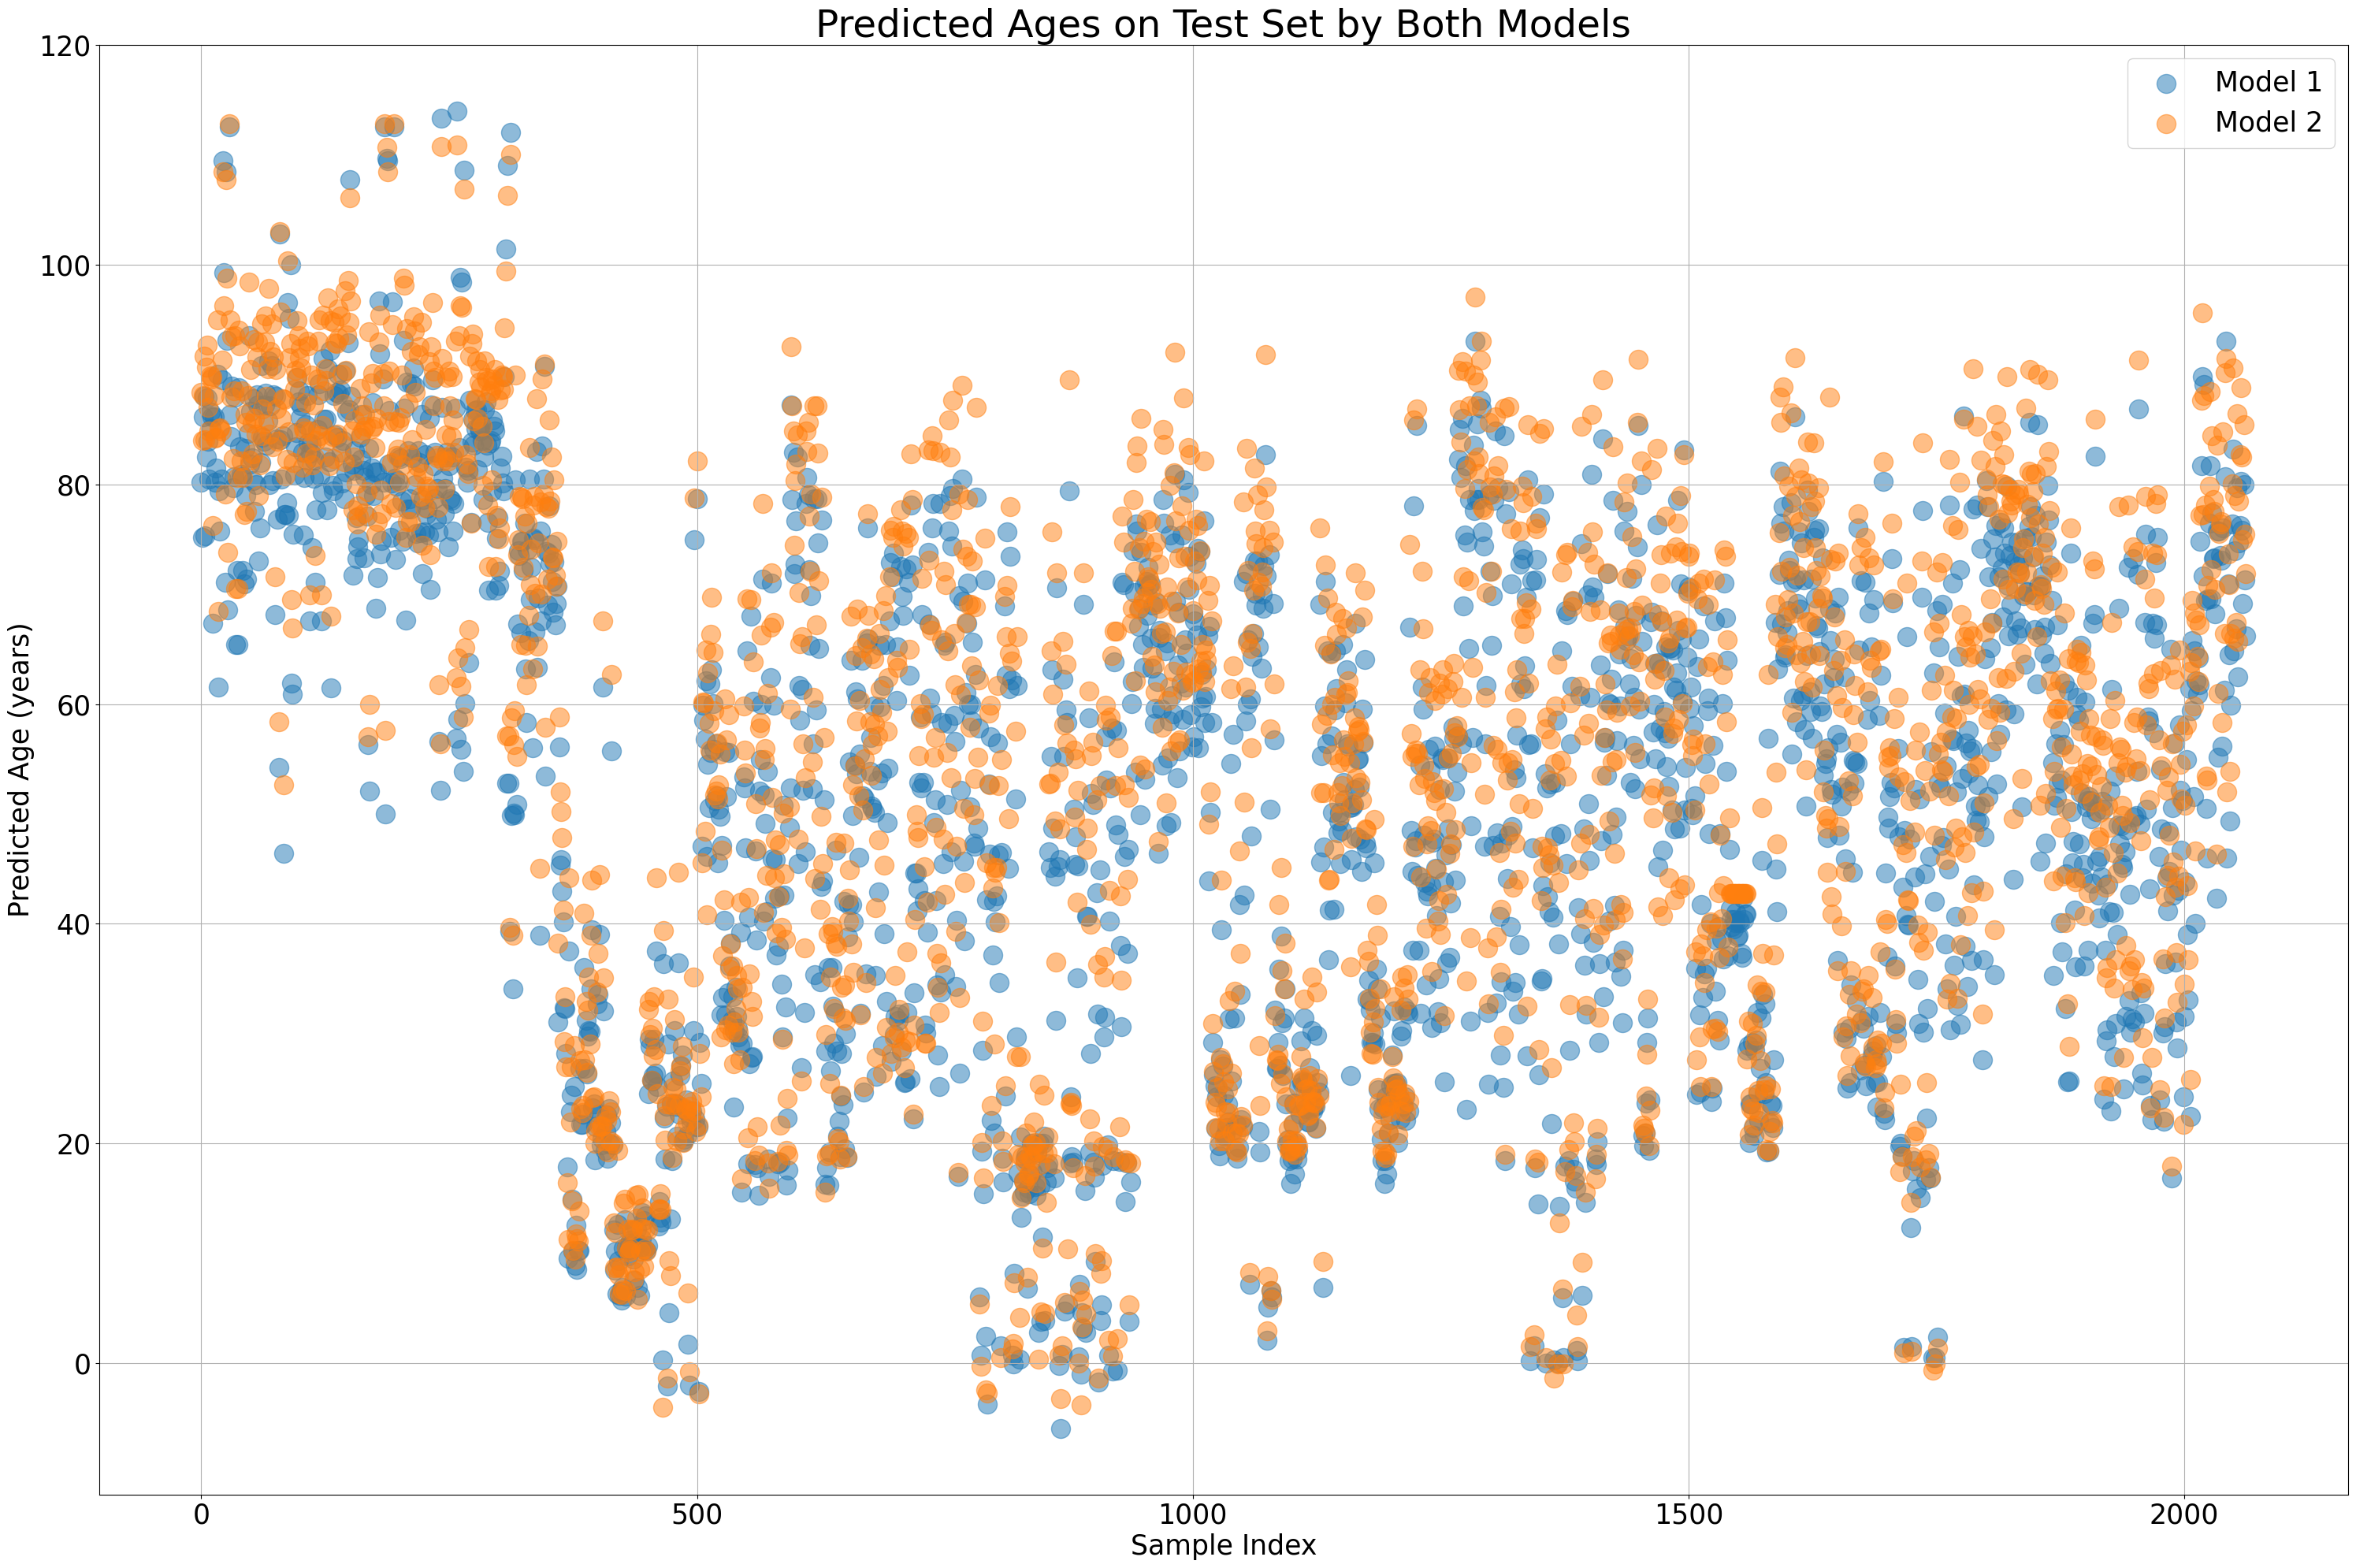

In [474]:
# Ensure predictions are sorted by sample index for clean visualization
plt.figure(figsize=(30, 20))

plt.scatter(range(len(test_pred_actual)), test_pred_actual, label='Model 1', alpha=0.5, s=300)
plt.scatter(range(len(test_pred_actual_2)), test_pred_actual_2, label='Model 2', alpha=0.5, s=300)

plt.xlabel('Sample Index', fontsize=25)
plt.ylabel('Predicted Age (years)', fontsize=25)
plt.title('Predicted Ages on Test Set by Both Models', fontsize=35)

plt.grid(True)
plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tight_layout()
plt.show()


Now, to get an exact measure, lets get a solid numerical evidence to see which model is actually performing better.

To determine which model performs better, I computed three evaluation metrics on the cross-validation (CV) set:

- **MAE (Mean Absolute Error):** Measures the average magnitude of the prediction errors, without considering their direction.
- **RMSE (Root Mean Squared Error):** Penalizes larger errors more than MAE, giving a sense of how concentrated the predictions are around the actual values.
- **R² (Coefficient of Determination):** Indicates how well the model explains the variance in the actual data (1.0 is perfect).

Below is the numerical comparison between Model 1 and Model 2:

In [475]:
# Model 1 metrics
mae_1 = mean_absolute_error(y_cv_actual, y_cv_pred_actual)
rmse_1 = np.sqrt(mean_squared_error(y_cv_actual, y_cv_pred_actual))
r2_1 = r2_score(y_cv_actual, y_cv_pred_actual)

# Model 2 metrics
mae_2 = mean_absolute_error(y_cv_actual_2, y_cv_pred_actual_2)
rmse_2 = np.sqrt(mean_squared_error(y_cv_actual_2, y_cv_pred_actual_2))
r2_2 = r2_score(y_cv_actual_2, y_cv_pred_actual_2)

print("Model Comparison (Cross Validation Set):")
print(f"Model 1 - MAE: {mae_1:.4f}, RMSE: {rmse_1:.4f}, R²: {r2_1:.4f}")
print(f"Model 2 - MAE: {mae_2:.4f}, RMSE: {rmse_2:.4f}, R²: {r2_2:.4f}")


Model Comparison (Cross Validation Set):
Model 1 - MAE: 4.7668, RMSE: 6.7929, R²: 0.9328
Model 2 - MAE: 4.4390, RMSE: 6.5872, R²: 0.9368


Hence the numbers prove it all, both models are indeed close in terms of performance but model 2 edges ahead of model 1. And most importantly model 2 is way more efficient due to less number of neurons and layers. Kind of proving why model 1 was an overkill.


Which means, a bigger neural network doesnt always imply a more accurate model!


Now, let us try to further improvise our model 2 using regularization.

### Model 3  
We will use L2 regularization (also called Ridge Regularization) on Model 2, keeping the rest of the architecture unchanged.  
A major task here is choosing the best value of $\lambda$, which depends on whether our model is overfitting or underfitting. If it is overfitting, we use a larger value of $\lambda$, and vice versa if it is underfitting.  

Here, I experimented with multiple values like 0.01 and 0.001, and finally settled on 0.0001, as it seemed to give the best balance — the previous two values led to underfitting.


In [329]:
model_3 = Sequential([
    # Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dense(64, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.0001)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),    
    Dense(1, activation='linear')  
])

C:\Users\Devansh Shah\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [330]:
model_3.compile(optimizer='adam', loss=MeanSquaredError())

Here, it might seem that we have trained the model only in 1 epoch but that actually is not the case. In reality, I trained the model in small chunks of steps to analyse it's performance and how much training led to the best results. So, approximately 100-130 steps were taken to train this model to its most accurate version.

In [411]:
model_3.fit(x_train, y_train, epochs=1)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0285


In [412]:
y_cvpred_3 = model_3.predict(x_cv)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [413]:
y_cv_actual_3 = age_scaler.inverse_transform(y_cv.reshape(-1, 1))
y_cv_pred_actual_3 = age_scaler.inverse_transform(y_cvpred_3.reshape(-1, 1))

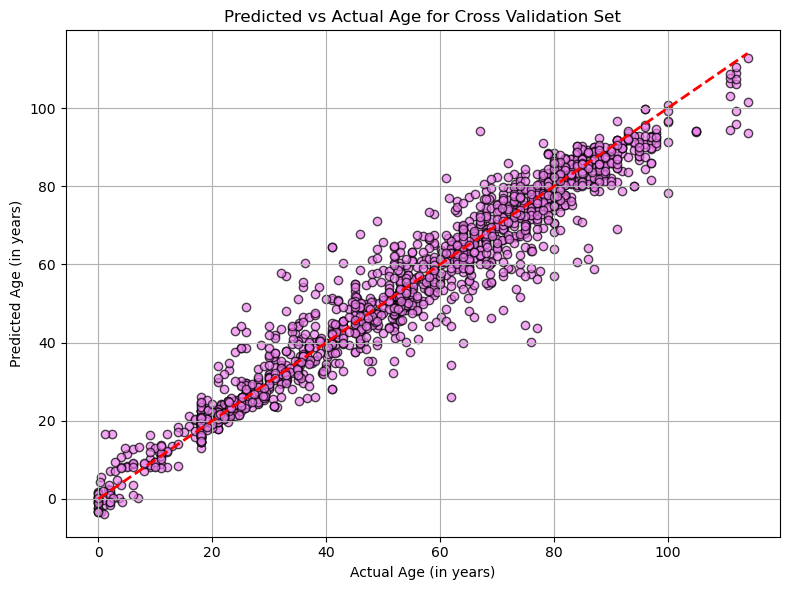

In [414]:
# this is the graph corresponding the cross validation set
plt.figure(figsize=(8, 6))
plt.scatter(y_cv_actual_3, y_cv_pred_actual_3, alpha=0.7, color='violet', edgecolors='k')
plt.plot([y_cv_actual_3.min(), y_cv_actual_3.max()], [y_cv_actual_3.min(), y_cv_actual_3.max()], 'r--', lw=2)  # y = x line
plt.xlabel('Actual Age (in years)')
plt.ylabel('Predicted Age (in years)')
plt.title('Predicted vs Actual Age for Cross Validation Set')
plt.grid(True)
plt.tight_layout()
plt.show()


In [476]:
test_pred_3 = model_3.predict(test_df)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [477]:
test_pred_actual_3 = age_scaler.inverse_transform(test_pred_3.reshape(-1, 1))

## Evaluation & Results

Now as we have all three models trained, let us plot them together for evaluation

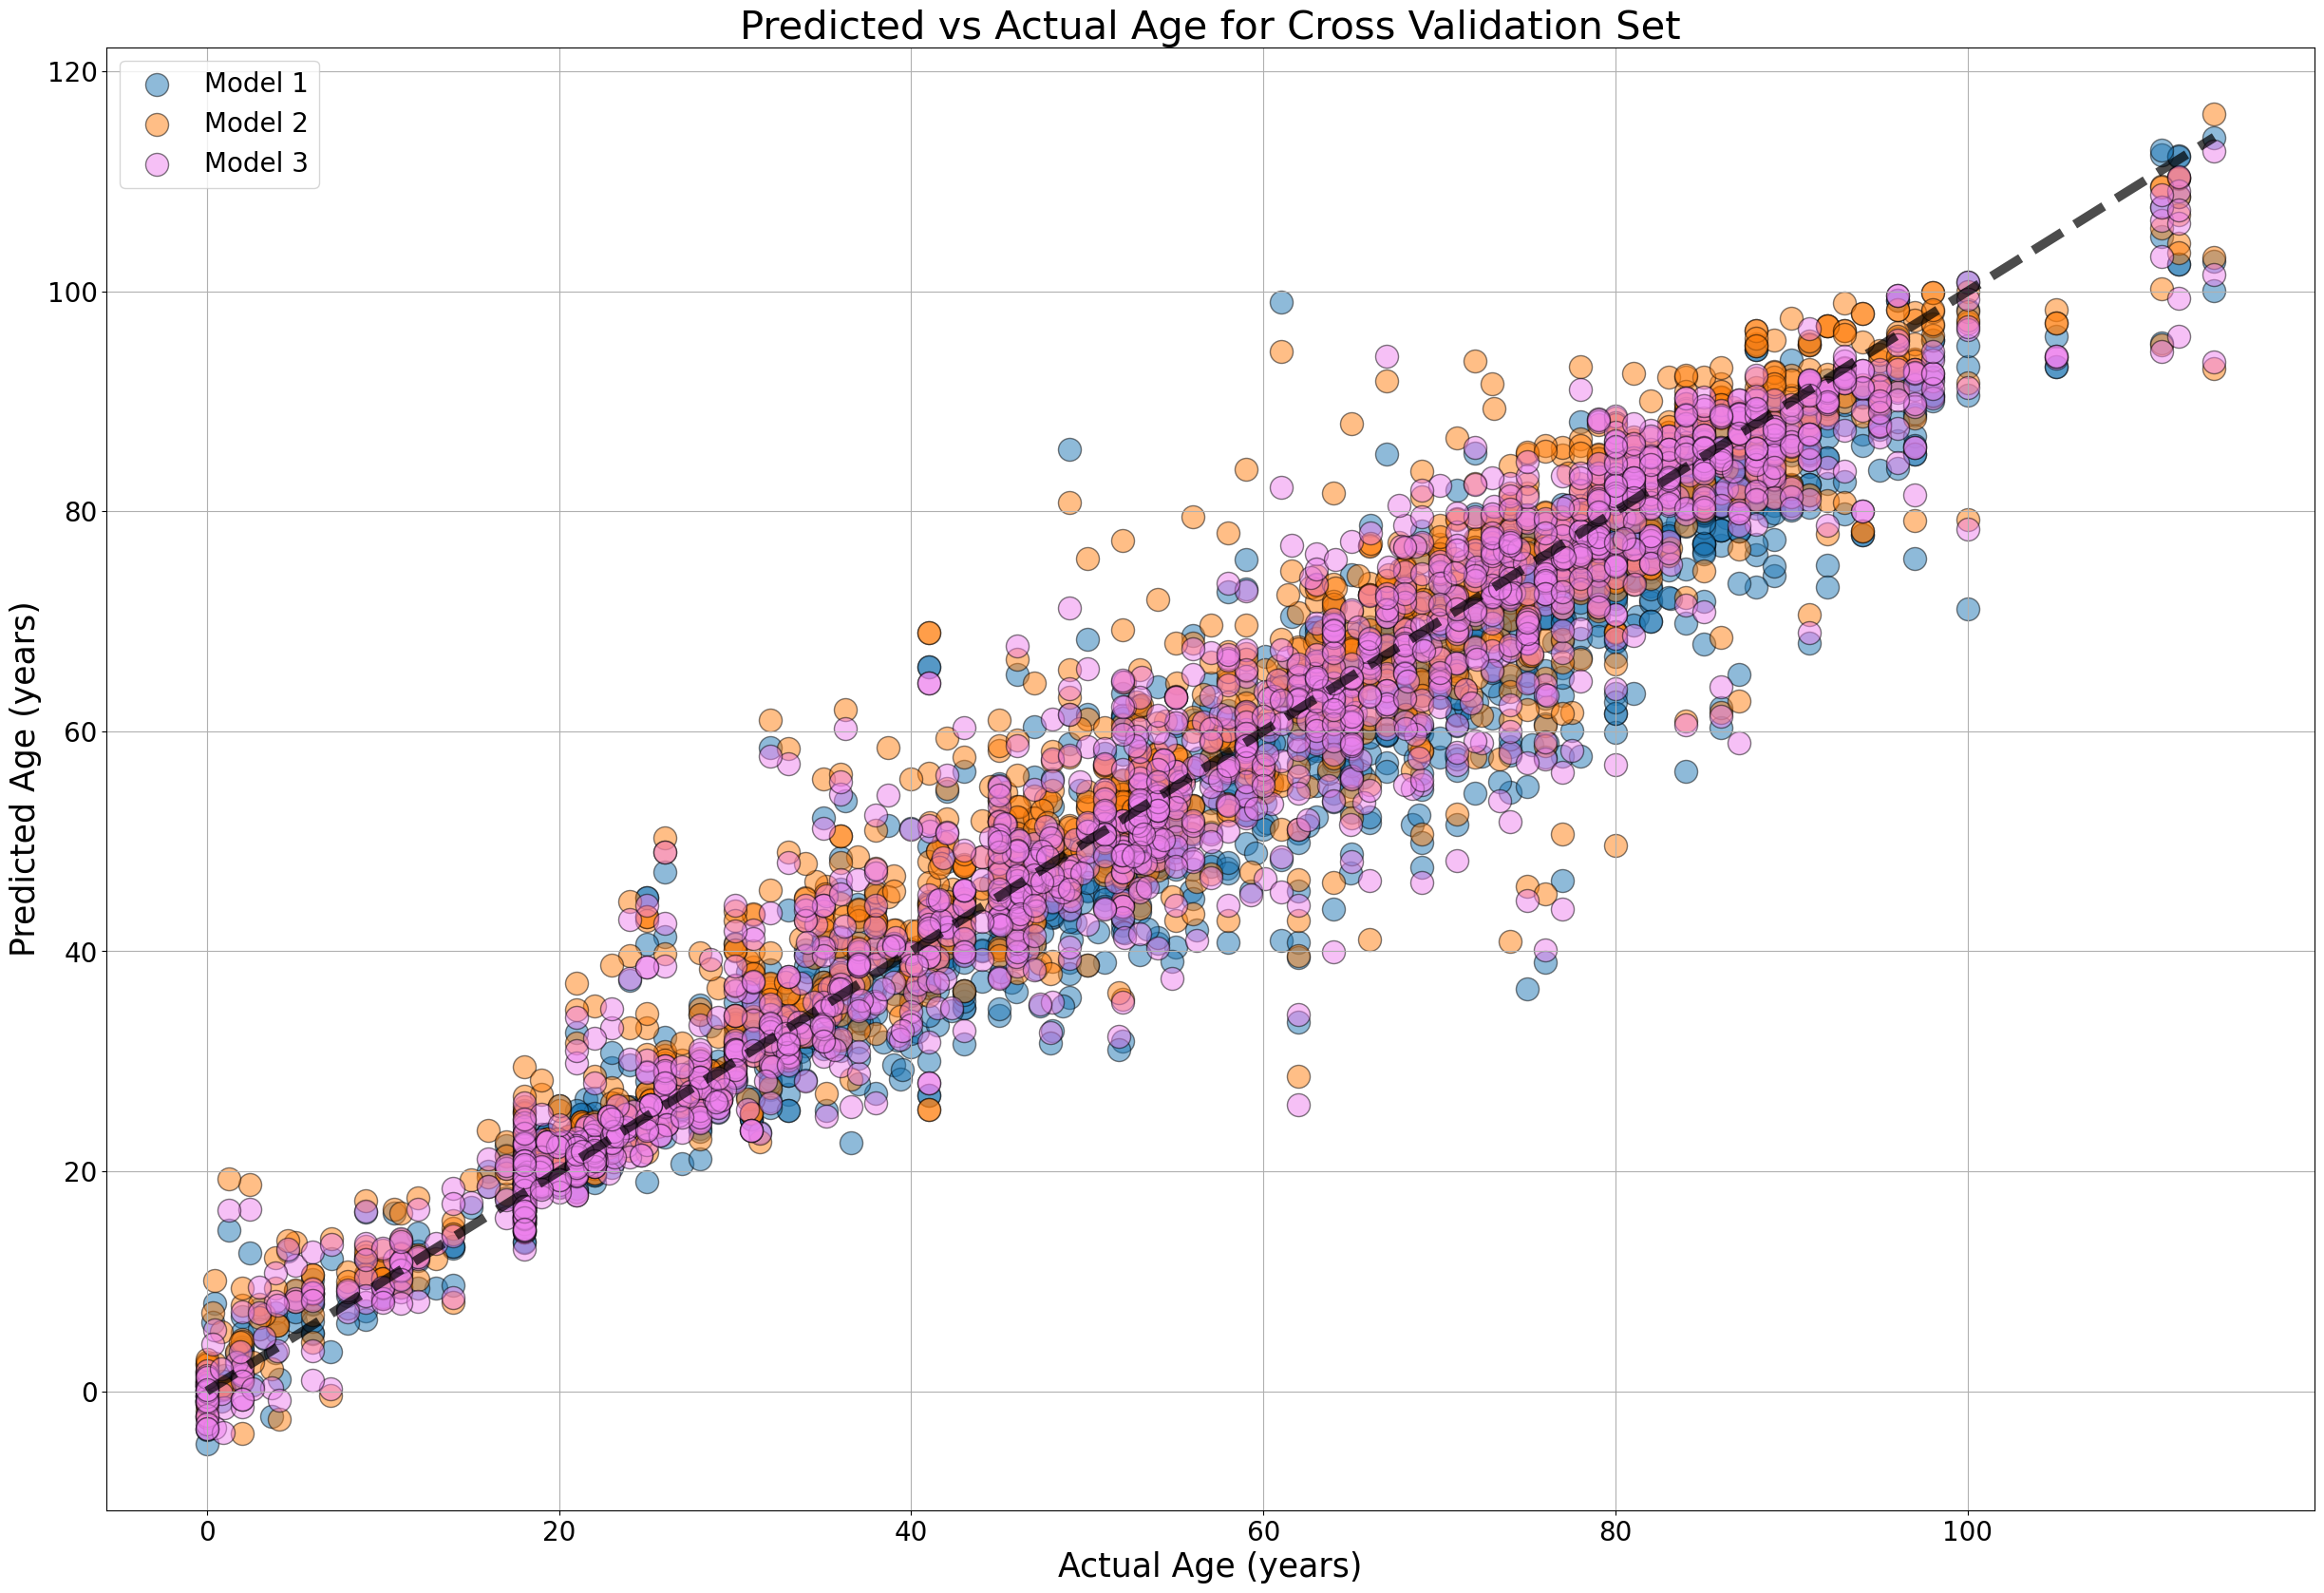

In [478]:
plt.figure(figsize=(30, 20))
plt.scatter(y_cv_actual, y_cv_pred_actual, label='Model 1', alpha=0.5, s=300, edgecolors='k')
plt.scatter(y_cv_actual_2, y_cv_pred_actual_2, label='Model 2', alpha=0.5, s=300, edgecolors='k')
plt.scatter(y_cv_actual_3, y_cv_pred_actual_3, label='Model 3', alpha=0.5, s=300, color='violet', edgecolors='k')
plt.plot([y_cv_actual_2.min(), y_cv_actual_2.max()], [y_cv_actual_2.min(), y_cv_actual_2.max()], 'k--', alpha=0.7, lw=7)
plt.xlabel('Actual Age (years)', fontsize=25)
plt.ylabel('Predicted Age (years)', fontsize=25)
plt.title('Predicted vs Actual Age for Cross Validation Set', fontsize=30)
plt.grid(True)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


Residual plots help us visualize the difference between the predicted and actual values, showing how much the model overpredicts or underpredicts across samples.

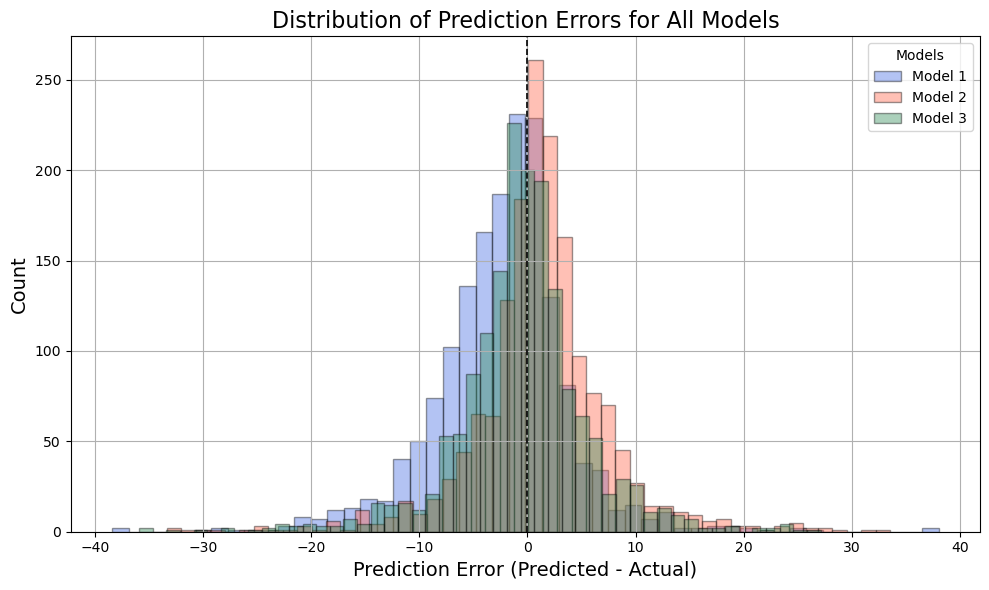

In [479]:
residuals = y_cv_pred_actual - y_cv_actual
residuals_2 = y_cv_pred_actual_2 - y_cv_actual_2
residuals_3 = y_cv_pred_actual_3 - y_cv_actual_3

plt.figure(figsize=(10, 6))

plt.hist(residuals, bins=50, alpha=0.4, color='royalblue', label='Model 1', edgecolor='black')
plt.hist(residuals_2, bins=50, alpha=0.4, color='tomato', label='Model 2', edgecolor='black')
plt.hist(residuals_3, bins=50, alpha=0.4, color='seagreen', label='Model 3', edgecolor='black')

plt.axvline(0, color='black', linestyle='dashed', linewidth=1.2)

plt.xlabel('Prediction Error (Predicted - Actual)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Prediction Errors for All Models', fontsize=16)
plt.legend(title='Models')
plt.grid(True)
plt.tight_layout()
plt.show()


As we can see from our residual histograms that model 1 and model 2 were under and overpredicting the age, respectively, hence the peaks being slightly away the zero line, our model 3 still isnt perfect, substantially improves in this regard.

In [480]:
# Model 1 metrics
mae_1 = mean_absolute_error(y_cv_actual, y_cv_pred_actual)
rmse_1 = np.sqrt(mean_squared_error(y_cv_actual, y_cv_pred_actual))
r2_1 = r2_score(y_cv_actual, y_cv_pred_actual)

# Model 2 metrics
mae_2 = mean_absolute_error(y_cv_actual_2, y_cv_pred_actual_2)
rmse_2 = np.sqrt(mean_squared_error(y_cv_actual_2, y_cv_pred_actual_2))
r2_2 = r2_score(y_cv_actual_2, y_cv_pred_actual_2)

# Model 3 metrics
mae_3 = mean_absolute_error(y_cv_actual_3, y_cv_pred_actual_3)
rmse_3 = np.sqrt(mean_squared_error(y_cv_actual_3, y_cv_pred_actual_3))
r2_3 = r2_score(y_cv_actual_3, y_cv_pred_actual_3)

print("Model Comparison (Cross Validation Set):")
print(f"Model 1 - MAE: {mae_1:.4f}, RMSE: {rmse_1:.4f}, R²: {r2_1:.4f}")
print(f"Model 2 - MAE: {mae_2:.4f}, RMSE: {rmse_2:.4f}, R²: {r2_2:.4f}")
print(f"Model 3 - MAE: {mae_3:.4f}, RMSE: {rmse_3:.4f}, R²: {r2_3:.4f}")

Model Comparison (Cross Validation Set):
Model 1 - MAE: 4.7668, RMSE: 6.7929, R²: 0.9328
Model 2 - MAE: 4.4390, RMSE: 6.5872, R²: 0.9368
Model 3 - MAE: 4.2583, RMSE: 6.2865, R²: 0.9425


So, finally as we can see, regularization did help and improved the accuracy of the model.

In [482]:
# saving all three models for future use
model.save("Biological_Age_Assessment_model_baseline.keras")
model_2.save("Biological_Age_Assessment_model_feature_adjusted.keras")
model_3.save("Biological_Age_Assessment_model_regularized.keras")

## Conclusion

Through iterative experimentation, we observed that while the base models (Model 1 and Model 2) performed reasonably well, they tended to slightly overpredict age, as evident from the right-shifted peaks in their residual histograms. Introducing L2 regularization in Model 3 not only mitigated this bias but also led to improved performance metrics (MAE: 4.25, RMSE: 6.28, R²: 0.9425), making it the most accurate and balanced model. Overall, regularization proved to be an effective strategy for enhancing model generalization and prediction reliability in age estimation based on methylation data.

Note: This is the best performance I was able to achieve. It's worth noting that the results might slightly improve with minor adjustments. Also, if you retrain the model yourself, you may get slightly different results — that's just a bit of randomness associated with model training. I've already taken steps to improve reproducibility as much as possible.

What Do These Errors Mean in Practice?

The **Mean Absolute Error (MAE)** of ~4.2 years means that on average, the model's predicted age is within 4.3 years of a person’s actual biological age.

The **Root Mean Squared Error (RMSE)** of ~6.2 years indicates that larger errors do occur, but they are infrequent — RMSE is more sensitive to outliers.

An **R²** of 0.9425 suggests that close to 94% of the variation in actual age can be explained by the model’s predictions, which is quite high for a biological system.

In real-world terms, this means that a person using this model can expect their predicted age to be accurate within **±4–6 years**, most of the time. For age estimation from methylation data — a biologically noisy and complex signal — this level of accuracy is not only statistically strong but also practically useful, especially in population studies, health diagnostics, or personalized aging analysis.